In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [2]:
from PSGpy.utils import read_out

In [3]:
names = ['#', 'low', 'high', 'path', 'P', 'Temp', 'boh', 'rho', 'CO2']
df = pd.read_csv('CO2_lyr.txt', names=names, sep = '\\s+')

In [4]:
float(df[df.low==0].Temp.iloc[0])

177.964

In [5]:
def find_nearest(array, value):
    aa = array[array < value]
    val = aa[np.argmax(aa)]
    return val

def fitted_line_plot(pp):
    xx = np.linspace(-60,60,100).reshape(-1,1)
    yy = np.polyval(pp,xx)
    print(f'Fitted coefficients: {pp.values}')
    plt.plot(xx,yy,color = 'red', linestyle = '--', label = 'cubic fit', lw = 2)

def check_plot(gas, freq, alt, ods, pp, fitted = True):
    toplot = ods.sel(freq = freq, altitude = alt, method='nearest')
    print(f'Plotting freq {toplot.freq.values} and alt {toplot.altitude.values}')
    toplotpp = pp.sel(freq = freq, altitude = alt, method='nearest')
    od = toplot.od.values
    mask = toplot.mask.values
    colors = np.where(mask == 1, "blue", "forestgreen")
    DT = toplot.DeltaT.values
    plt.style.use('ggplot')
    plt.scatter(DT, od, c = colors, marker = 'o', label=f'simulated data')
   # plt.plot(T+DT, od, fmt='o', label=f'simulated data', color = 'blue')
    plt.xlabel(r'$\Delta$T [K]', fontsize = 16)
    plt.ylabel(r'Optical Depth ($\tau$)', fontsize = 16)
    plt.title(f'gas = {gas}, ' + r'$\nu$ ' + f'= {freq}, h = {toplot.altitude.values}', fontsize = 18)
    if fitted:
        fitted_line_plot(toplotpp)
    plt.legend(fontsize = 16, facecolor = 'white')
    plt.show()

Plotting freq 2124.2900000007485 and alt 27.438
Fitted coefficients: [-7.56800722e-12 -2.18894267e-09  2.00767472e-07  3.83462647e-06
 -4.28336457e-04  7.00474408e-02]


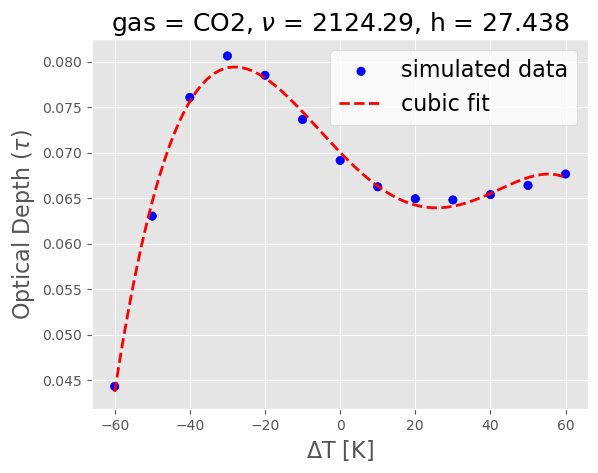

In [17]:
FF = 2124.29
AA = 26

degree = 5

gas = 'CO2'

ranges = np.arange(90, 3050, 40)
coeff_path = '/home/buriola/OD4Mars/NO_BACKUP/data/coeff/'
od_path = '/home/buriola/OD4Mars/NO_BACKUP/data/od/'
freq1 = find_nearest(ranges, FF) 
freq2 = freq1 + 40
ds = xr.open_dataset(f'{od_path}{gas}/od_{gas}_freq{freq1}_{freq2}.nc')
pp = xr.open_dataset(f'{coeff_path}{gas}/coeff_{degree}_{gas}_freq{freq1}_{freq2}.nc')
#ppyerr = xr.open_dataset(f'{coeff_path}{gas}/coeff_{degree}_yer_{gas}_freq{freq1}_{freq2}.nc')
check_plot(gas, FF, AA, ds, pp.coeff)

In [24]:
ds = xr.open_dataset(f'{od_path}{gas}/od_{gas}_freq{freq1}_{freq2}.nc')
toplot = ds.sel(freq = 581.77, altitude = 40, method='nearest')
data = toplot.od.values
dt = toplot.DeltaT.values

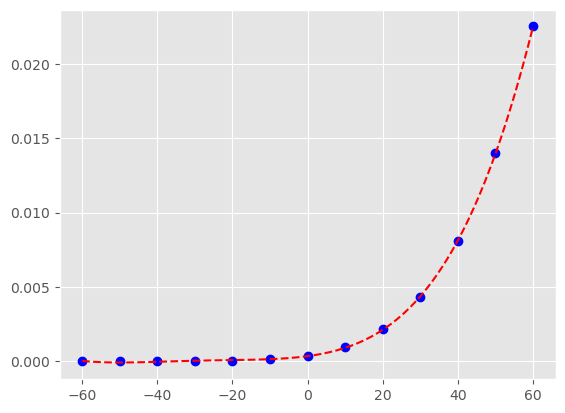

In [29]:
coeff = np.polyfit(dt, data, 4)
plt.plot(dt, data, 'bo')
xx = np.linspace(-60,60,100).reshape(-1,1)
yy = np.polyval(coeff,xx)
plt.plot(xx,yy,color = 'red', linestyle = '--', label = 'fit')


In [30]:
yy

array([[ 3.89792518e-05],
       [ 1.11528960e-05],
       [-1.17408022e-05],
       [-3.01406168e-05],
       [-4.44666968e-05],
       [-5.51205658e-05],
       [-6.24851225e-05],
       [-6.69246400e-05],
       [-6.87847663e-05],
       [-6.83925242e-05],
       [-6.60563113e-05],
       [-6.20658999e-05],
       [-5.66924371e-05],
       [-5.01884447e-05],
       [-4.27878195e-05],
       [-3.47058327e-05],
       [-2.61391305e-05],
       [-1.72657340e-05],
       [-8.24503880e-06],
       [ 7.82184627e-07],
       [ 9.69379101e-06],
       [ 1.83862603e-05],
       [ 2.67746978e-05],
       [ 3.47928339e-05],
       [ 4.23930242e-05],
       [ 4.95462497e-05],
       [ 5.62421164e-05],
       [ 6.24888559e-05],
       [ 6.83133245e-05],
       [ 7.37610043e-05],
       [ 7.88960022e-05],
       [ 8.38010505e-05],
       [ 8.85775067e-05],
       [ 9.33453536e-05],
       [ 9.82431991e-05],
       [ 1.03428277e-04],
       [ 1.09076444e-04],
       [ 1.15382186e-04],
       [ 1.2

In [8]:
degree = 3
pp = xr.open_dataset(f'{coeff_path}{gas}/coeff_{degree}_{gas}_freq{freq1}_{freq2}.nc')
pp

<xarray.Dataset> Size: 7MB
Dimensions:   (freq: 4000, altitude: 55, degree: 4)
Coordinates:
  * freq      (freq) float64 32kB 690.0 690.0 690.0 690.0 ... 730.0 730.0 730.0
  * altitude  (altitude) float64 440B 0.0 3.829 4.393 ... 137.5 154.7 172.7
  * degree    (degree) int32 16B 3 2 1 0
Data variables:
    coeff     (freq, altitude, degree) float64 7MB ...
    mask0     (freq, altitude) bool 220kB ...

In [19]:
def datamerge(gas):
    od_lr = []
    od_fitted = []
    for i in range(len(ranges)-1):
        tab = xr.open_dataset(f'{coeff_path}{gas}/coeff_{degree}_{gas}_freq{ranges[i]}_{ranges[i+1]}.nc')
        coeff = tab['coeff']
        od = xr.open_dataset(f'{od_path}{gas}/od_{gas}_freq{ranges[i]}_{ranges[i+1]}.nc')
        fitted = xr.polyval(od.DeltaT, coeff)
        
        od = od['od']
        
        mask0 = od.min(dim='DeltaT') > 1e-8
        od = xr.where(mask0,  od, 1e-8)     
        fitted = xr.where(mask0, fitted, 1e-8)
        fitted = xr.where(fitted < 1e-8, 1e-8, fitted)   

        od_lr.append(od)
        od_fitted.append(fitted)
    
    od_lr = xr.concat(od_lr, 'freq')
    od_fitted = xr.concat(od_fitted, 'freq')

    DS = xr.Dataset({
        'true': od_lr,
        'fitted': od_fitted,
    })

    return DS

In [ ]:
tot_ds = datamerge('CO2')

In [ ]:
tot_ds

<xarray.Dataset> Size: 3GB
Dimensions:   (freq: 292000, altitude: 55, DeltaT: 13)
Coordinates:
  * freq      (freq) float64 2MB 90.0 90.01 90.02 ... 3.01e+03 3.01e+03 3.01e+03
  * altitude  (altitude) float64 440B 0.0 3.829 4.393 ... 137.5 154.7 172.7
  * DeltaT    (DeltaT) int32 52B -60 -50 -40 -30 -20 -10 0 10 20 30 40 50 60
Data variables:
    true      (freq, altitude, DeltaT) float64 2GB 1e-08 1e-08 ... 1e-08 1e-08
    fitted    (freq, altitude, DeltaT) float64 2GB 1e-08 1e-08 ... 1e-08 1e-08

In [14]:
dsT_todo = np.exp(-tot_ds)

In [15]:
dsT = dsT_todo.sel(freq = slice(500,700), altitude = slice(20,120))

In [16]:
mask = (dsT.true < 0.99) & (dsT.true > 0.00)
dsT = dsT.where(mask, drop=True)

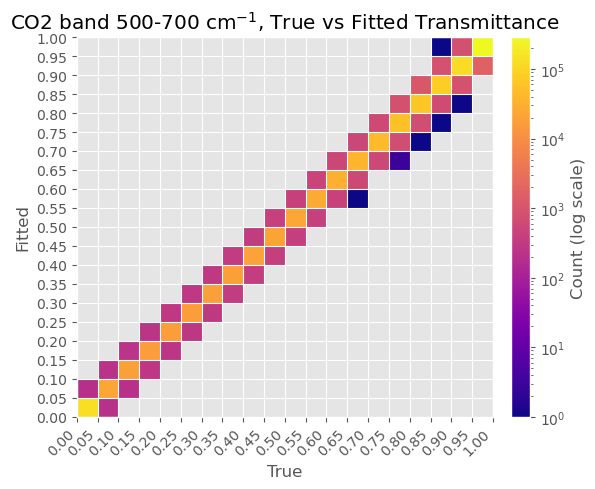

In [17]:
import pandas as pd
from matplotlib.colors import LogNorm

df = pd.DataFrame({
    "true": dsT.true.values.ravel(),
    "fitted": dsT.fitted.values.ravel()
})

# --- Define custom bin edges (10 classes) ---
bin_edges = np.linspace(0, 1, 21)   # change this to your own edges

# --- Bin using custom edges ---
true_bins = pd.cut(df["true"], bins=bin_edges, include_lowest=True)
fitted_bins = pd.cut(df["fitted"], bins=bin_edges, include_lowest=True)

df["true_bin"] = true_bins
df["fitted_bin"] = fitted_bins

# Crosstab counts
counts = pd.crosstab(df["true_bin"], df["fitted_bin"])
matrix = counts.values

# --- Plot with imshow ---
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(matrix.T, cmap="plasma", origin="lower", 
               extent=[bin_edges[0], bin_edges[-1], bin_edges[0], bin_edges[-1]],
               aspect="auto", norm=LogNorm(vmin=1, vmax=matrix.max()))

# Axis labels
ax.set_ylabel("Fitted")
ax.set_xlabel("True")

# Tick marks at bin edges
ax.set_xticks([b for b in bin_edges])
ax.set_yticks([b for b in bin_edges])

# Rotate labels if needed
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Count (log scale)")
ax.set_title("CO2 band 500-700 cm$^{-1}$, True vs Fitted Transmittance")
plt.tight_layout()
plt.show()

In [18]:
dsT = dsT_todo.sel(freq = slice(2200,2400), altitude = slice(20,120), DeltaT = slice(-60,40))
mask = (dsT.true < 0.99) & (dsT.true > 0.00)
dsT = dsT.where(mask, drop=True)

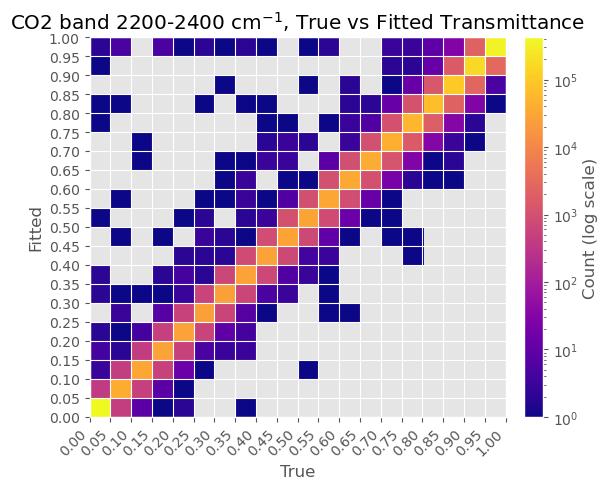

In [20]:
df = pd.DataFrame({
    "true": dsT.true.values.ravel(),
    "fitted": dsT.fitted.values.ravel()
})

# --- Define custom bin edges (10 classes) ---
bin_edges = np.linspace(0, 1, 21)   # change this to your own edges

# --- Bin using custom edges ---
true_bins = pd.cut(df["true"], bins=bin_edges, include_lowest=True)
fitted_bins = pd.cut(df["fitted"], bins=bin_edges, include_lowest=True)

df["true_bin"] = true_bins
df["fitted_bin"] = fitted_bins

# Crosstab counts
counts = pd.crosstab(df["true_bin"], df["fitted_bin"])
matrix = counts.values

# --- Plot with imshow ---
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(matrix.T, cmap="plasma", origin="lower", 
               extent=[bin_edges[0], bin_edges[-1], bin_edges[0], bin_edges[-1]],
               aspect="auto", norm=LogNorm(vmin=1, vmax=matrix.max()))

# Axis labels
ax.set_ylabel("Fitted")
ax.set_xlabel("True")

# Tick marks at bin edges
ax.set_xticks([b for b in bin_edges])
ax.set_yticks([b for b in bin_edges])

# Rotate labels if needed
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Count (log scale)")
ax.set_title("CO2 band 2200-2400 cm$^{-1}$, True vs Fitted Transmittance")
plt.tight_layout()
plt.show()

In [21]:
trueT = np.exp(-tot_ds['true'])
fittedT = np.exp(-tot_ds['fitted'])

In [22]:
fittedT = fittedT.transpose('freq','altitude','DeltaT')

In [23]:
mask = (trueT > 0.01) & (trueT < 0.99)

In [24]:
true_vals = trueT.where(mask).values

In [25]:
true_vals.shape

(292000, 55, 13)

KeyboardInterrupt: 

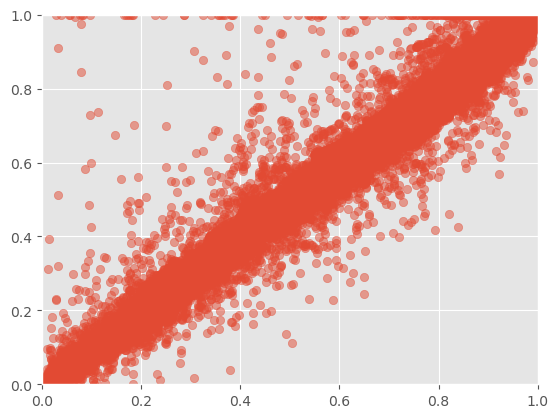

In [26]:
# Mask values below threshold
mask = (trueT > 0.01) & (trueT < 0.99)

true_vals = trueT.where(mask)
fitted_vals = fittedT.where(mask)

# Convert to 1D for plotting
plt.scatter(true_vals.values.ravel(), fitted_vals.values.ravel(), alpha=0.5)
plt.xlabel("True")
plt.ylabel("Fitted")
plt.show()
